In [8]:
#!/usr/bin/env python
# mnist_idx_svm.py  –  Full MNIST workflow from raw IDX files
# -----------------------------------------------------------
import struct, pathlib, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    
    accuracy_score, classification_report,
    ConfusionMatrixDisplay
)
from joblib import dump

In [9]:
import struct,numpy as np
from pathlib import Path 

def read_idx(path: pathlib.Path) -> np.ndarray:
    """
    Read an IDX file (MNIST format) and return it as a NumPy array.
    Works for both images (*.idx3-ubyte) and labels (*.idx1-ubyte).
    """
    with path.open("rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        ndim  = magic & 0xFF                   # lower byte has #dims
        shape = tuple(int.from_bytes(f.read(4), "big") for _ in range(ndim))
        data  = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(shape)


DATA_DIR = Path(r"C:\Users\Owner\Desktop\Projects\21-Handwritten Digit Classification (SVM)\data")


train_images = read_idx(DATA_DIR / "train-images.idx3-ubyte")  # (60000, 28, 28)
train_labels = read_idx(DATA_DIR / "train-labels.idx1-ubyte")  # (60000,)
test_images  = read_idx(DATA_DIR / "t10k-images.idx3-ubyte")   # (10000, 28, 28)
test_labels  = read_idx(DATA_DIR / "t10k-labels.idx1-ubyte")   # (10000,)

print("Shapes →",
      f"train: {train_images.shape} / {train_labels.shape},",
      f"test:  {test_images.shape} / {test_labels.shape}")

# Flatten 28×28 images → 784-D vectors
X_train = train_images.reshape(-1, 28*28).astype(np.float32)
y_train = train_labels.astype(np.int8)
X_test  = test_images.reshape(-1, 28*28).astype(np.float32)
y_test  = test_labels.astype(np.int8)

Shapes → train: (60000, 28, 28) / (60000,), test:  (10000, 28, 28) / (10000,)


In [10]:
# 3. RBF-SVM pipeline + hyper-parameter search ---------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),          # zero-mean / unit-var
    # Un-comment PCA to cut fit time ~8× with ≈0.2 pp loss in accuracy
    # ("pca",    PCA(0.95, whiten=True, random_state=42)),
    ("svc",    SVC(kernel="rbf"))
])

In [22]:
param_grid = {
    "svc__C":     [1, 5, 10, 50],
    "svc__gamma": [1e-3, 5e-4, 1e-4]
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

print("\n— Grid-searching RBF-SVM (this can take a few minutes)…")
t0 = time.time()
gs = GridSearchCV(pipe, param_grid, cv=cv,
                  n_jobs=-1, verbose=2, scoring="accuracy")
gs.fit(X_train, y_train)
print(f"Grid search done in {(time.time()-t0)/60:.1f} min")

print("Best CV accuracy:", gs.best_score_)
print("Best params:", gs.best_params_)

best_svm = gs.best_estimator_


— Grid-searching RBF-SVM (this can take a few minutes)…
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Grid search done in 46.1 min
Best CV accuracy: 0.96495
Best params: {'svc__C': 10, 'svc__gamma': 0.001}



Test accuracy: 0.9733
              precision    recall  f1-score   support

           0     0.9827    0.9878    0.9852       980
           1     0.9860    0.9938    0.9899      1135
           2     0.9681    0.9700    0.9690      1032
           3     0.9743    0.9752    0.9748      1010
           4     0.9735    0.9715    0.9725       982
           5     0.9654    0.9686    0.9670       892
           6     0.9873    0.9760    0.9816       958
           7     0.9506    0.9728    0.9615      1028
           8     0.9729    0.9569    0.9648       974
           9     0.9718    0.9574    0.9646      1009

    accuracy                         0.9733     10000
   macro avg     0.9733    0.9730    0.9731     10000
weighted avg     0.9734    0.9733    0.9733     10000



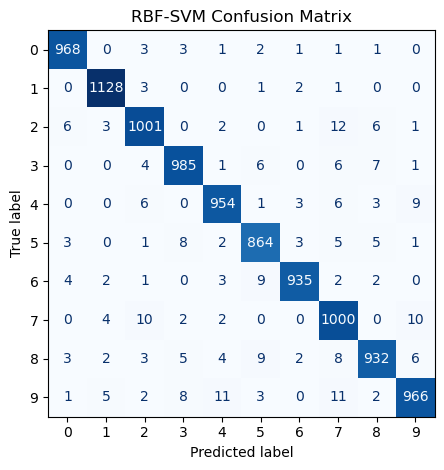

In [24]:
pipe.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", colorbar=False
).ax_.set_title("RBF-SVM Confusion Matrix")
plt.tight_layout()
plt.show()

In [21]:
# 5. Two quick baselines for comparison ----------------------------
baselines = {
    "k-NN (k=3)": Pipeline([
        ("scaler", StandardScaler()),
        ("knn",    KNeighborsClassifier(
                       n_neighbors=5,
                       weights="distance",
                       n_jobs=-1))
    ]),
    "Logistic Reg": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
   #                  multi_class="multinomial",
   #                  solver="saga",
                     C=10, max_iter=1000,
                     n_jobs=-1, random_state=42))
    ])
}

print("\n— Baseline models —")
for name, model in baselines.items():
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"{name:13s}: {acc:.4f}")



— Baseline models —
k-NN (k=3)   : 0.9450
Logistic Reg : 0.9202


In [25]:
# ------------------------------------------------------------------
# 6. Save the tuned SVM for later use ------------------------------
dump(best_svm, "mnist_rbf_svm.joblib")
print("\nModel saved → mnist_rbf_svm.joblib")


Model saved → mnist_rbf_svm.joblib
